In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 학습/평가 데이터 로드
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# '[.]'을 '.'으로 복구
train_df['URL'] = train_df['URL'].str.replace(r'\[\.\]', '.', regex=True)
test_df['URL'] = test_df['URL'].str.replace(r'\[\.\]', '.', regex=True)

In [3]:
# URL 길이
train_df['length'] = train_df['URL'].str.len()
test_df['length'] = test_df['URL'].str.len()

# 서브도메인 개수
train_df['subdomain_count'] = train_df['URL'].str.split('.').apply(lambda x: len(x) - 2)
test_df['subdomain_count'] = test_df['URL'].str.split('.').apply(lambda x: len(x) - 2)

# 특수 문자('-', '_', '/') 개수
train_df['special_char_count'] = train_df['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))
test_df['special_char_count'] = test_df['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))

In [4]:
short_url_services = ['bit.ly', 'tinyurl.com', 't.co', 'goo.gl', 'is.gd', 'ow.ly', 
                      'buff.ly', 'shorte.st', 'adf.ly', 'rebrandly.com', 'mcaf.ee', 
                      'bl.ink', 'soo.gd', 'cutt.ly', 'clck.ru', 'rb.gy', 't.ly', 
                      'u.to', 'v.gd', 'x.co', 'lnkd.in', 'po.st', 'qr.ae', 'ht.ly', 'chilp.it']

def is_short_url(url):
    for domain in short_url_services:
        if domain in url:
            return 1  # 단축 URL
    return 0  # 일반 URL

train_df['short_url'] = train_df['URL'].apply(is_short_url)
test_df['short_url'] = test_df['URL'].apply(is_short_url)

In [5]:
# https로 시작 유무
train_df['https'] = train_df['URL'].apply(lambda x: 0 if x.startswith('https') else 1)
test_df['https'] = test_df['URL'].apply(lambda x: 0 if x.startswith('https') else 1)

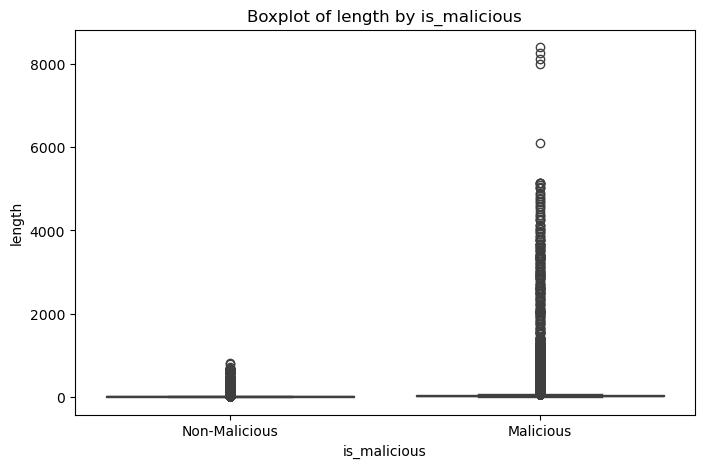

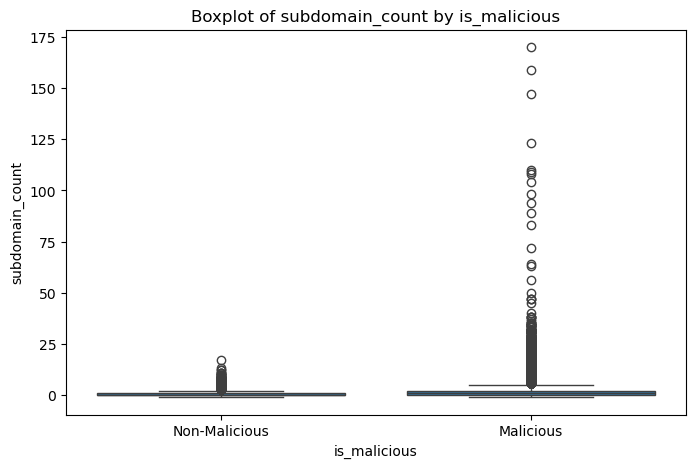

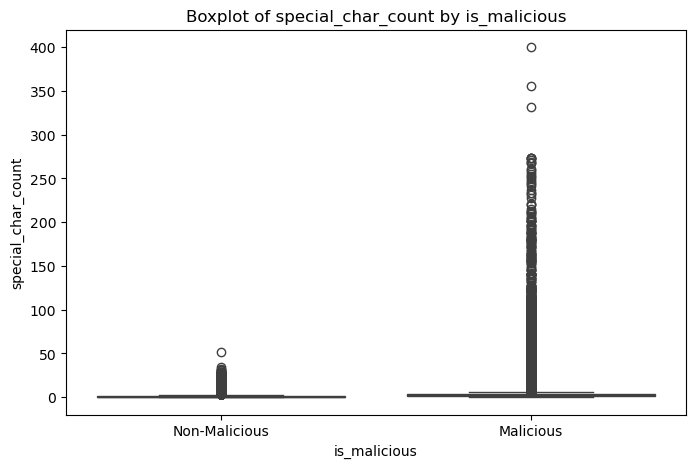

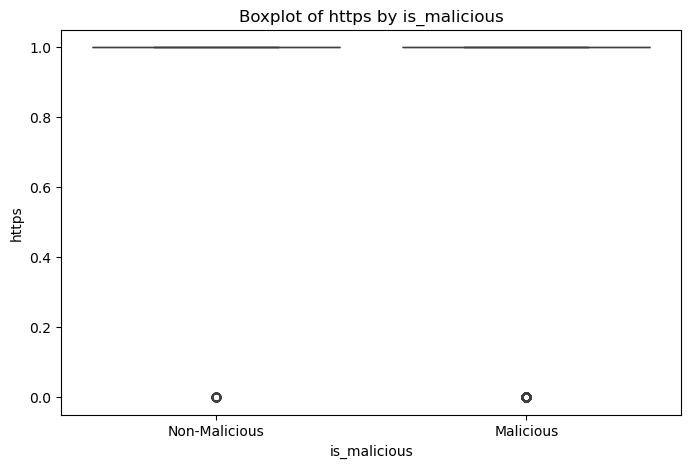

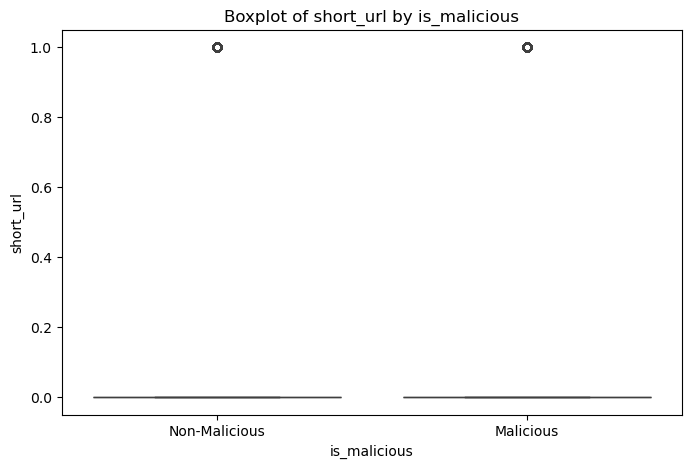

In [6]:
## 악성 여부에 따른 분포 확인
# 변수 목록
variables = ['length', 'subdomain_count', 'special_char_count', 'https', 'short_url']

# 박스플롯
for var in variables:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=train_df, x='label', y=var)
    plt.title(f"Boxplot of {var} by is_malicious")
    plt.xlabel("is_malicious")
    plt.ylabel(var)
    plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
    plt.show()

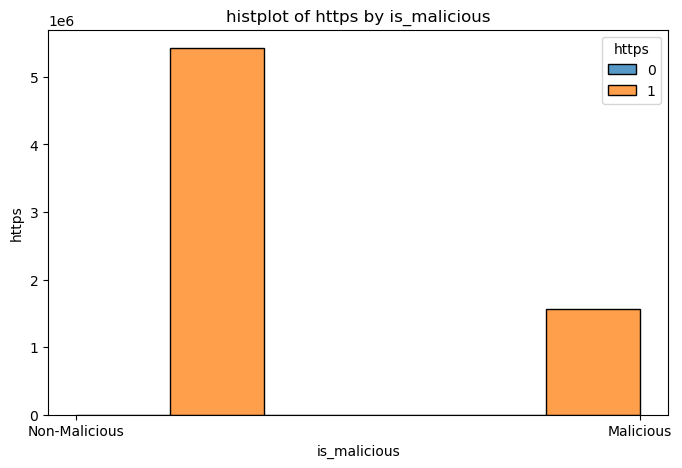

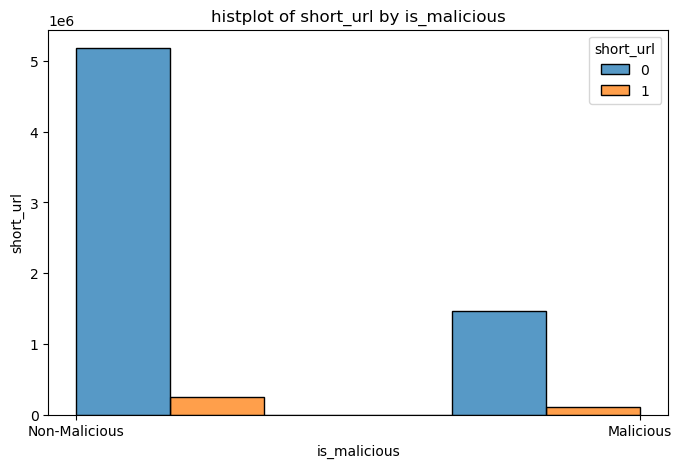

In [13]:
variables_2 = ['https', 'short_url']

for var in variables_2:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=train_df, hue=var, x='label', bins=3, multiple='dodge')
    plt.title(f"histplot of {var} by is_malicious")
    plt.xlabel("is_malicious")
    plt.ylabel(var)
    plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
    plt.show()

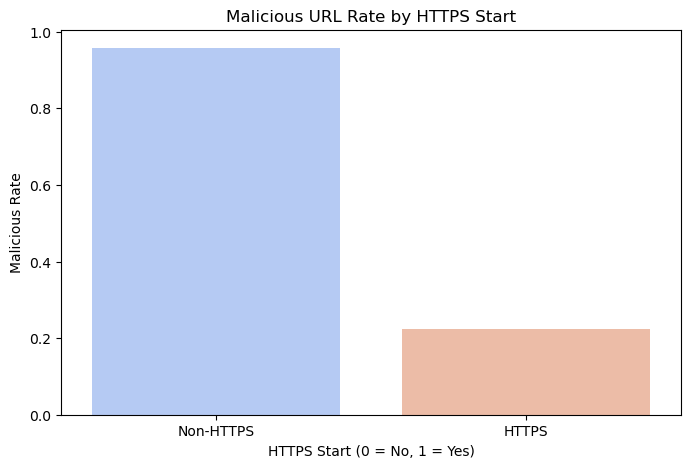

In [14]:
# https로 시작하는지 여부와 악성 여부를 기준으로 비율 계산
https_malicious_ratio = train_df.groupby('https')['label'].mean()

# https로 시작하는 것과 시작하지 않는 것에 대해 악성 비율을 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=https_malicious_ratio.index, y=https_malicious_ratio.values, palette='coolwarm')
plt.title("Malicious URL Rate by HTTPS Start")
plt.xlabel("HTTPS Start (0 = No, 1 = Yes)")
plt.ylabel("Malicious Rate")
plt.xticks([0, 1], ['Non-HTTPS', 'HTTPS'])
plt.show()

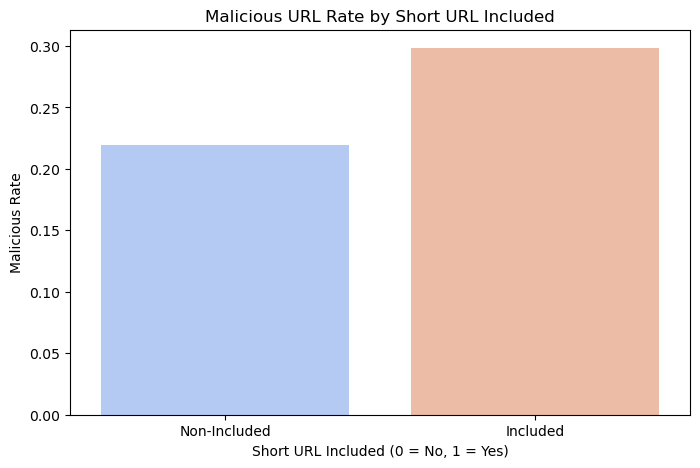

In [15]:
# 단축 url를 포함하는지 여부와 악성 여부를 기준으로 비율 계산
short_url_malicious_ratio = train_df.groupby('short_url')['label'].mean()

# 단축 URL을 포함하는 것과 포함하지 않는 것에 대해 악성 비율을 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=short_url_malicious_ratio.index, y=short_url_malicious_ratio.values, palette='coolwarm')
plt.title("Malicious URL Rate by Short URL Included")
plt.xlabel("Short URL Included (0 = No, 1 = Yes)")
plt.ylabel("Malicious Rate")
plt.xticks([0, 1], ['Non-Included', 'Included'])
plt.show()

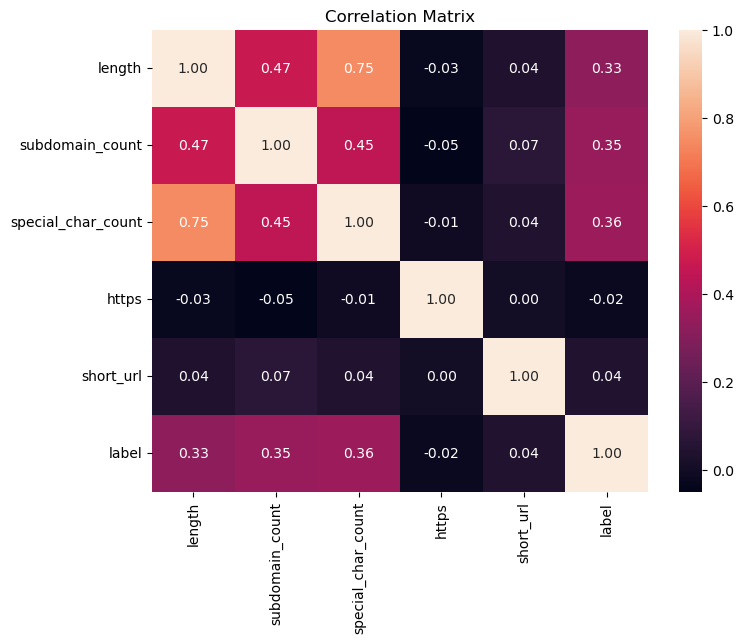

In [8]:
# 상관계수 계산
correlation_matrix = train_df[['length', 'subdomain_count', 'special_char_count', 'https', 'short_url', 'label']].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [11]:
# 학습을 위한 학습 데이터의 피처와 라벨 준비
X = train_df[['length', 'subdomain_count', 'special_char_count', 'https', 'short_url']]
y = train_df['label']

# 추론을 위한 평가 데이터의 피처 준비
X_test = test_df[['length', 'subdomain_count', 'special_char_count', 'https', 'short_url']]

In [12]:
# XGBoost 학습 및 모델 저장 (K-Fold)
kf = KFold(n_splits=4, shuffle=True, random_state=42)
models = []  # 모델을 저장할 리스트
auc_scores = []

for idx, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    print('-'*40)
    print(f'Fold {idx + 1} 번째 XGBoost 모델을 학습합니다.')
    print('Epoch|         Train AUC             |         Validation AUC')
    
    # XGBoost 모델 학습
    model = XGBClassifier(
        n_estimators=100, 
        max_depth=6,       
        learning_rate=0.1, 
        random_state=42,
        use_label_encoder=False,  
        eval_metric="auc",        
    )
    
    # 학습 및 Validation 성능 모니터링
    eval_set = [(X_train, y_train), (X_val, y_val)]
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        verbose=True,  
        # early_stopping_rounds=5  
    )
    
    models.append(model)  # 모델 저장
    
    # 검증 데이터 예측 및 ROC-AUC 계산
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred_prob)
    print(f"Fold {idx + 1} CV ROC-AUC: {auc:.4f}")
    print('-'*40)
    auc_scores.append(auc)

print(f"K-Fold 평균 ROC-AUC: {np.mean(auc_scores):.4f}")

----------------------------------------
Fold 1 번째 XGBoost 모델을 학습합니다.
Epoch|         Train AUC             |         Validation AUC
[0]	validation_0-auc:0.86179	validation_1-auc:0.86121
[1]	validation_0-auc:0.86446	validation_1-auc:0.86382
[2]	validation_0-auc:0.86535	validation_1-auc:0.86476
[3]	validation_0-auc:0.86548	validation_1-auc:0.86493
[4]	validation_0-auc:0.86567	validation_1-auc:0.86512
[5]	validation_0-auc:0.86588	validation_1-auc:0.86536
[6]	validation_0-auc:0.86595	validation_1-auc:0.86544
[7]	validation_0-auc:0.86596	validation_1-auc:0.86546
[8]	validation_0-auc:0.86614	validation_1-auc:0.86564
[9]	validation_0-auc:0.86638	validation_1-auc:0.86587
[10]	validation_0-auc:0.86644	validation_1-auc:0.86593
[11]	validation_0-auc:0.86656	validation_1-auc:0.86605
[12]	validation_0-auc:0.86657	validation_1-auc:0.86608
[13]	validation_0-auc:0.86666	validation_1-auc:0.86617
[14]	validation_0-auc:0.86673	validation_1-auc:0.86623
[15]	validation_0-auc:0.86668	validation_1-auc:0.8661

In [13]:
# 평가 데이터 추론
# 각 Fold 별 모델의 예측 확률 계산
test_probabilities = np.zeros(len(X_test)) 

for model in models:
    test_probabilities += model.predict_proba(X_test)[:, 1]  # 악성 URL(1)일 확률 합산

# Soft-Voting 앙상블 (Fold 별 모델들의 예측 확률 평균)
test_probabilities /= len(models)
print('Inference Done.')

Inference Done.


In [14]:
# 결과 저장
test_df['probability'] = test_probabilities
test_df[['ID', 'probability']].to_csv('./submission.csv', index=False)
print('Done.')

Done.
